In [2]:
import cv2
import copy
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from matplotlib import pyplot as plt
from torchvision.utils import save_image
from tqdm.notebook import tqdm

from aijack.attack import GradientInversion_Attack
from aijack.utils import NumpyDataset


In [3]:
torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
class LeNet(nn.Module):
    def __init__(self, channel=1, hideen=588, num_classes=10):
        super(LeNet, self).__init__()
        act = nn.Sigmoid
        self.body = nn.Sequential(
            nn.Conv2d(channel, 12, kernel_size=5, padding=5 // 2, stride=2),
            nn.BatchNorm2d(12),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5 // 2, stride=2),
            nn.BatchNorm2d(12),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5 // 2, stride=1),
            nn.BatchNorm2d(12),
            act(),
        )
        self.fc = nn.Sequential(
            nn.Linear(hideen, num_classes)
        )

    def forward(self, x):
        out = self.body(x)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [5]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [7]:
#################################
##### Neural Network model #####
#################################

class VGG(nn.Module):
    def __init__(self, channels=1, hideen=12544, num_classes=10):
        super(VGG, self).__init__()
        self.body = nn.Sequential(
            nn.Conv2d(channels, 32, kernel_size=(3,3), stride=(2,2), padding=1),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Dropout(0.5),
            nn.Conv2d(32, 64, kernel_size=(3,3), padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Dropout(0.5),
            nn.Conv2d(64, 128, kernel_size=(3,3), stride=(2,2), padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Dropout(0.5),
            nn.Conv2d(128, 256, kernel_size=(3,3), padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Dropout(0.5),
            nn.Flatten()
        )
        self.fc = nn.Sequential(
            nn.Linear(12544, num_classes)
            # nn.Linear(hideen, num_classes)
        )

    def forward(self, x):
        out = self.body(x)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [8]:
train_loader = [torch.utils.data.DataLoader(x, batch_size=1, shuffle=True) for x in torch.load('../data/MNIST.pth')]
for i in range(len(train_loader)):
    client_img = []
    client_label = []
    dataiter = iter(train_loader[i])
    for batch_idx in range(len(train_loader[i])):
        print("Client "+ str(i) +" | batch "+str(batch_idx) + " | total imgs " + str(len(client_img)))
        images, labels = dataiter.next()
        print(labels.shape)

Client 0 | batch 0 | total imgs 0
torch.Size([1])
Client 0 | batch 1 | total imgs 0
torch.Size([1])
Client 0 | batch 2 | total imgs 0
torch.Size([1])
Client 0 | batch 3 | total imgs 0
torch.Size([1])
Client 0 | batch 4 | total imgs 0
torch.Size([1])
Client 0 | batch 5 | total imgs 0
torch.Size([1])
Client 0 | batch 6 | total imgs 0
torch.Size([1])
Client 0 | batch 7 | total imgs 0
torch.Size([1])
Client 0 | batch 8 | total imgs 0
torch.Size([1])
Client 0 | batch 9 | total imgs 0
torch.Size([1])
Client 0 | batch 10 | total imgs 0
torch.Size([1])
Client 0 | batch 11 | total imgs 0
torch.Size([1])
Client 0 | batch 12 | total imgs 0
torch.Size([1])
Client 0 | batch 13 | total imgs 0
torch.Size([1])
Client 0 | batch 14 | total imgs 0
torch.Size([1])
Client 0 | batch 15 | total imgs 0
torch.Size([1])
Client 0 | batch 16 | total imgs 0
torch.Size([1])
Client 0 | batch 17 | total imgs 0
torch.Size([1])
Client 0 | batch 18 | total imgs 0
torch.Size([1])
Client 0 | batch 19 | total imgs 0
torch.

426


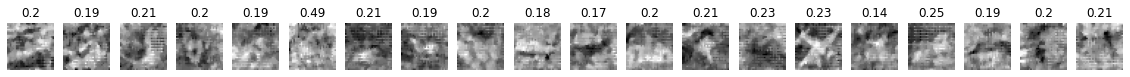

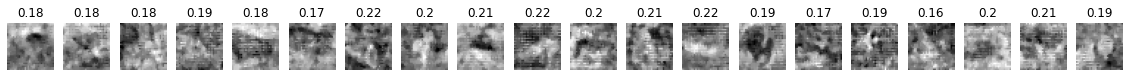

In [21]:
import math
from scipy.signal import convolve2d

images = torch.load('generated_images.pth')
images1 = torch.load('generated_images3.pth')
# for i in range(10):
#   images[i] += images1[i]

def estimate_noise(I):
  H, W = I.shape
  M = [[1, -2, 1],
       [-2, 4, -2],
       [1, -2, 1]]
  sigma = np.sum(np.sum(np.absolute(convolve2d(I, M))))
  sigma = sigma * math.sqrt(0.5 * math.pi) / (6 * (W-2) * (H-2))

  return round(sigma, 2)

# for i in range(10):
#   images[i] += images1[i]
total_imgs = 0

for i in range(10):
  imgs = images[i]
  imgs = [img[:, :, 0] for img in imgs if estimate_noise(np.array(cv2.medianBlur(img.numpy()[:, :, 0],3))) < 0.5]
  
  images[i] = imgs
  total_imgs += len(images[i])
print(total_imgs)

for i in range(2):
    fig = plt.figure(figsize=(20, 20))
    for bid in range(20):
        ax1 = fig.add_subplot(1, 20, bid+1)
        img1 = images[1][bid+20*i]
        model = torch.load("../pretrained/test_torch.pt")
        img1 = np.array(cv2.medianBlur(img1.numpy(),3))
        
        # test = np.transpose(img1, (2, 1, 0))
        test = np.expand_dims(img1, axis=0)
        test = np.expand_dims(test, axis=0)
        
        tc_img = torch.tensor(test).cuda()
        # output = model(tc_img)
        # pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        # pred = pred.cpu().detach().numpy()[0][0]
        
        ax1.imshow(img1, cmap="gray_r")
        # ax1.set_title(pred)
        # ax1.set_title(labels[1][bid+25*i])
        ax1.set_title(estimate_noise(img1))
        ax1.axis("off")

In [13]:
from random import randint
randint(0,1)


In [17]:
def draw_out(attacker, received_gradients, batch_size=0):
    num_seeds=3
    fig = plt.figure()
    fig.set_figheight(7)
    fig.set_figwidth(7)
    for s in tqdm(range(num_seeds)):
        attacker.reset_seed(s)
        if batch_size > 0:
            result = attacker.attack(received_gradients, batch_size=batch_size)
        else:
            result = attacker.attack(received_gradients)
        ax1 = fig.add_subplot(3, num_seeds, s+1)
        test_img = torch.from_numpy((result[0].cpu().detach().numpy()[0])) / 2 + 0.5
        img1 = test_img.swapaxes(0,1)
        img1 = img1.swapaxes(1,2)
        ax1.imshow(torchvision.utils.make_grid(img1))
        ax1.set_title(torch.argmax(result[1]).item())
        ax1.axis("off")
        ax2 = fig.add_subplot(3, num_seeds, num_seeds+s+1)
        ax2.imshow(result[0].cpu().detach().numpy()[0][0], cmap="gray")
        ax2.axis("off")
        ax3 = fig.add_subplot(3, num_seeds, num_seeds + num_seeds+s+1)
        ax3.imshow(cv2.medianBlur(result[0].cpu().detach().numpy()[0][0], 5), cmap="gray")
        ax3.axis("off")
    plt.suptitle("Result")
    plt.tight_layout()
    plt.show()


d:\Projects\TRUSTCOM2022\.venv\lib\site-packages\torchvision\datasets\mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
d:\Projects\TRUSTCOM2022\.venv\lib\site-packages\torchvision\datasets\mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


## DLG Attack
https://dlg.mit.edu/assets/NeurIPS19_deep_leakage_from_gradients.pdf

- distance metric = L2 norm
- optimize both of images and labels

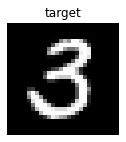

  0%|          | 0/5 [00:00<?, ?it/s]

iter=65: loss did not improve in the last 50 rounds.
iter=64: loss did not improve in the last 50 rounds.
iter=68: loss did not improve in the last 50 rounds.
iter=71: loss did not improve in the last 50 rounds.
iter=66: loss did not improve in the last 50 rounds.


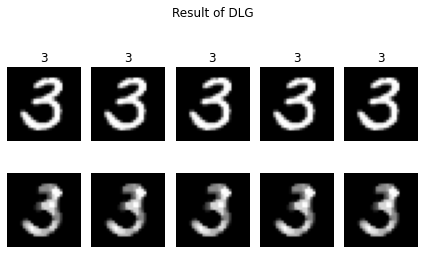

In [18]:
imshow(torchvision.utils.make_grid(images[0].cpu()))
print("Target")
criterion = nn.CrossEntropyLoss()
net = LeNet(channel=3, hideen=768, num_classes=10)
net.to(device)
pred = net(images[:1])
loss = criterion(pred, labels[:1])
received_gradients = torch.autograd.grad(loss, net.parameters())
received_gradients = [cg.detach() for cg in received_gradients]

dlg_attacker = GradientInversion_Attack(net, (3, 32, 32), lr=1.0, log_interval=0,
                                    num_iteration=1000,
                                    distancename="l2", device=device)

draw_out(dlg_attacker, received_gradients)

## GS Attack
https://arxiv.org/abs/2003.14053
- distance metric = cosine similarity
- optimize both of images and labels
- total-variance regularization

In [ ]:
# imshow(torchvision.utils.make_grid(images[0].cpu()))

# criterion = nn.CrossEntropyLoss()
# net = LeNet(channel=3, hideen=768, num_classes=10)
# net.to(device)
# pred = net(images[:1])
# loss = criterion(pred, labels[:1])
# received_gradients = torch.autograd.grad(loss, net.parameters())
# received_gradients = [cg.detach() for cg in received_gradients]

# gs_attacker = GradientInversion_Attack(net, (3, 32, 32), lr=1.0, log_interval=0,
#                                     num_iteration=200,
#                                     tv_reg_coef=0.01,
#                                     distancename="cossim", device=device)

# draw_out(gs_attacker, received_gradients)

## IDLG Attack
https://arxiv.org/abs/2001.02610
- distance metric = L2 norm
- optimize only an image & estimate a label from the gradients

In [ ]:
imshow(torchvision.utils.make_grid(images[0].cpu()))

criterion = nn.CrossEntropyLoss()
net = LeNet(channel=3, hideen=768, num_classes=10)
net.to(device)
pred = net(images[:1])
loss = criterion(pred, labels[:1])
received_gradients = torch.autograd.grad(loss, net.parameters())
received_gradients = [cg.detach() for cg in received_gradients]

idlg_attacker = GradientInversion_Attack(net, (3, 32, 32), lr=10e2, log_interval=0,
                                    optimizer_class=torch.optim.SGD,
                                    distancename="l2", optimize_label=False,
                                    num_iteration=10000, device=device)

draw_out(idlg_attacker, received_gradients)

## CPL Attack
https://arxiv.org/abs/2004.10397
- distance metric = L2 norm
- optimize only images & estimate an label from the gradients
- label-matching regularization

In [ ]:
import torch.optim as optim

imshow(torchvision.utils.make_grid(images[0].cpu()))

criterion = nn.CrossEntropyLoss()
net = LeNet(channel=3, hideen=768, num_classes=10)
net.to(device)
# optimizer = optim.SGD(net.parameters(), lr=0.1)
# for epoch in range(10):
pred = net(images[:1])
loss = criterion(pred, labels[:1])
loss.backward(retain_graph=True)
received_gradients = torch.autograd.grad(loss, net.parameters())
received_gradients = [cg.detach()for cg in received_gradients]

cpl_attacker = GradientInversion_Attack(net, (3, 32, 32), lr=10e2, log_interval=0,
                                    optimizer_class=torch.optim.SGD,
                                    distancename="l2", optimize_label=False,
                                    num_iteration=10000,
                                    lm_reg_coef=0.01, device=device)

draw_out(cpl_attacker, received_gradients)

    # optimizer.step()


## GradInversion
https://arxiv.org/abs/2104.07586
- distance metric = L2 norm
- optimize only images & estimate labels from the gradients
- total-variance, l2, bn, and group-consistency regularization

In [ ]:
import cv2
import copy
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from matplotlib import pyplot as plt
from torchvision.utils import save_image
from tqdm.notebook import tqdm

from aijack.attack import GradientInversion_Attack
from aijack.utils import NumpyDataset

def prepare_dataloader(path="MNIST/.", batch_size = 64, shuffle=True):
    at_t_dataset_train = torchvision.datasets.MNIST(
        root=path, train=True, download=True
    )

    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
    )

    dataset = NumpyDataset(
        at_t_dataset_train.train_data.numpy(),
        at_t_dataset_train.train_labels.numpy(),
        transform=transform,
    )

    dataloader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=shuffle, num_workers=0
    )
    return dataloader


dataloader = prepare_dataloader()
for data in dataloader:
    x, y = data[0], data[1]
    break

batch_size = 3

for i in range(3):
    fig = plt.figure(figsize=(3, 2))
    for bi in range(batch_size):
        ax = fig.add_subplot(1, batch_size, bi+1)
        ax.imshow(x[bi+batch_size*i].detach().numpy()[0], cmap="gray")
        ax.axis("off")
    plt.suptitle("target")
    plt.tight_layout()
    plt.show()

    criterion = nn.CrossEntropyLoss()
    net = LeNet()
    pred = net(x[batch_size*i:batch_size+batch_size*i])
    loss = criterion(pred, y[batch_size*i:batch_size+batch_size*i])
    received_gradients = torch.autograd.grad(loss, net.parameters())
    received_gradients = [cg.detach() for cg in received_gradients]

    gradinversion = GradientInversion_Attack(net, (1, 28, 28), num_iteration=1200,
                                        lr=1e2, log_interval=0,
                                        optimizer_class=torch.optim.SGD,
                                        distancename="l2", optimize_label=False,
                                        bn_reg_layers=[net.body[1], net.body[4], net.body[7]],
                                        group_num = 10,
                                        tv_reg_coef=0.00, l2_reg_coef=0.0001,
                                        bn_reg_coef=0.001, gc_reg_coef=0.001)

    result = gradinversion.group_attack(received_gradients, batch_size=batch_size)

    fig = plt.figure()
    for bid in range(batch_size):
        ax1 = fig.add_subplot(2, batch_size, bid+1)
        ax1.imshow((sum(result[0]) / len(result[0])).detach().numpy()[bid][0], cmap="gray")
        ax1.axis("off")
        ax1.set_title(result[1][0][bid].item())
        im = (sum(result[0]) / len(result[0])).detach().numpy()[bid][0]
        ax2 = fig.add_subplot(2, batch_size, batch_size+bid+1)
        ax2.imshow(cv2.medianBlur(im, 3), cmap="gray")
        ax2.axis("off")

    plt.suptitle("Result of GradInversion")
    plt.show()